In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from binaryIV import simulate_deterministic_data_with_probabilistic_ate, extract_prob_dict, entropy_of_array

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



import matplotlib.pyplot as plt
import seaborn as sns
import math
# from linearmodels.iv import IV2SLS
import statsmodels.api as sm
import statsmodels.formula.api as smf


pd.options.mode.chained_assignment = None  # default='warn'


pd.set_option('display.max_columns', None)




In [2]:
data  = pd.read_pickle('binaryIV_results.pkl')

<Axes: ylabel='Frequency'>

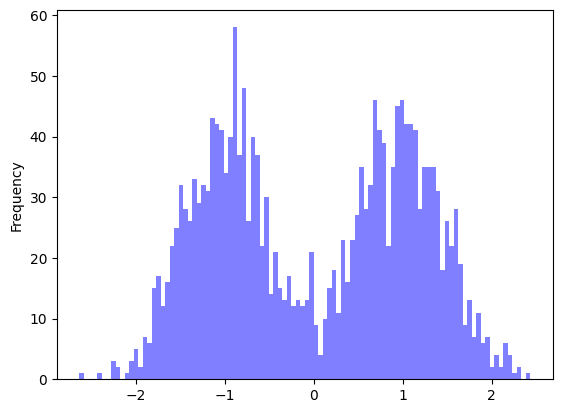

In [4]:
data['b_Z'].plot(kind='hist', bins=100, alpha=0.5, label='b_Z', color='blue')

In [14]:
print(data.columns.tolist())


['seed', 'intercept_X', 'intercept_Y', 'b_X_Y', 'b_Z', 'b_U_X', 'b_U_Y', 'ATE_true', 'p_Y1', 'p_Y0', 'Z', 'U', 'X', 'Y', 'entropy_Y', 'entropy_X', 'entropy_Z', 'entropy_U', 'corr_X_Y', 'corr_X_Z', 'corr_Y_Z', 'causaloptim_bound_lower', 'causaloptim_bound_upper', 'causaloptim_bound_width', 'causaloptim_bounds_valid', '2SLS_CI_level_percent', '2SLS_estimation', '2SLS_CI_lower', '2SLS_CI_upper', '2SLS_CI_width', '2SLS_CI_valid', 'entropyBounds_H(conf)_UB', 'entropyBounds_bound_lower', 'entropyBounds_bound_upper', 'entropyBounds_bound_width', 'entropyBounds_bounds_valid', 'autobound_bound_lower', 'autobound_bound_upper', 'autobound_bound_width', 'autobound_bounds_valid', 'ATE_true_smooth', 'autobound_bound_lower_smooth', 'autobound_bound_upper_smooth']


In [15]:
# Add a new column 'tightest_bounds' to identify the algorithm with the smallest bound width
bound_columns = {
    'causaloptim': 'causaloptim_bound_width',
    '2SLS': '2SLS_CI_width',
    'entropyBounds': 'entropyBounds_bound_width',
    'autobound': 'autobound_bound_width'
}
data['tightest_bounds'] = data[
    list(bound_columns.values())
].idxmin(axis=1).map({v: k for k, v in bound_columns.items()})

<Axes: xlabel='tightest_bounds'>

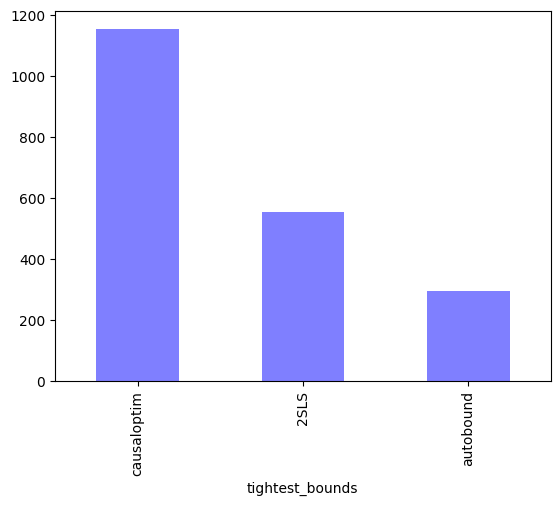

In [19]:
data['tightest_bounds'].value_counts().plot(kind='bar', alpha=0.5, color='blue')

In [26]:
# Train a decision tree classifier to predict 'tightest_bounds'
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define features and target
features = ['entropy_Y', 'entropy_X', 'entropy_Z', 'corr_X_Y', 'corr_X_Z', 'corr_Y_Z']
X = data[features]
y = data['tightest_bounds']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Evaluate the classifier
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        2SLS       0.74      0.80      0.77       108
   autobound       0.32      0.37      0.34        57
 causaloptim       0.74      0.69      0.71       235

    accuracy                           0.67       400
   macro avg       0.60      0.62      0.61       400
weighted avg       0.68      0.67      0.68       400



In [27]:
# Train a random forest classifier to predict 'tightest_bounds'
from sklearn.ensemble import RandomForestClassifier

# Train the random forest classifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
rf_clf.fit(X_train, y_train)

# Evaluate the random forest classifier
rf_y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

        2SLS       0.80      0.83      0.81       108
   autobound       0.36      0.16      0.22        57
 causaloptim       0.76      0.84      0.80       235

    accuracy                           0.74       400
   macro avg       0.64      0.61      0.61       400
weighted avg       0.71      0.74      0.72       400



In [31]:
# Train a neural network classifier to predict 'tightest_bounds'
from sklearn.neural_network import MLPClassifier

# Train the neural network classifier
nn_clf = MLPClassifier(random_state=42, max_iter=500, hidden_layer_sizes=(100, 50))
nn_clf.fit(X_train, y_train)

# Evaluate the neural network classifier
nn_y_pred = nn_clf.predict(X_test)
print(classification_report(y_test, nn_y_pred))

              precision    recall  f1-score   support

        2SLS       0.81      0.80      0.80       108
   autobound       0.52      0.21      0.30        57
 causaloptim       0.76      0.87      0.81       235

    accuracy                           0.76       400
   macro avg       0.70      0.63      0.64       400
weighted avg       0.74      0.76      0.74       400



In [ ]:
# Hyperparameter tuning for the neural network using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50), (150, 100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(
    estimator=MLPClassifier(random_state=42, max_iter=500),
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=3,
    verbose=2
)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and F1 score
print('Best Parameters:', grid_search.best_params_)
print('Best F1 Score:', grid_search.best_score_)

# Evaluate the best model on the test set
best_nn_clf = grid_search.best_estimator_
nn_y_pred = best_nn_clf.predict(X_test)
print(classification_report(y_test, nn_y_pred))

# Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
# Best F1 Score: 0.7356598398204732
#               precision    recall  f1-score   support

#         2SLS       0.89      0.70      0.79       108
#    autobound       0.50      0.21      0.30        57
#  causaloptim       0.74      0.91      0.81       235

#     accuracy                           0.76       400
#    macro avg       0.71      0.61      0.63       400
# weighted avg       0.74      0.76      0.73       400

# Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'constant', 'solver': 'adam'}
# Best F1 Score: 0.7356598398204732
#               precision    recall  f1-score   support

#         2SLS       0.89      0.70      0.79       108
#    autobound       0.50      0.21      0.30        57
#  causaloptim       0.74      0.91      0.81       235

#     accuracy                           0.76       400
#    macro avg       0.71      0.61      0.63       400
# weighted avg       0.74      0.76      0.73       400


Fitting 3 folds for each of 32 candidates, totalling 96 fits


C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   1.8s


C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:697: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   0.4s


C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=adam; total time=   1.9s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.2s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=constant, solver=sgd; total time=   0.2s


C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.6s


C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.6s


C:\Users\tmari\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=adam; total time=   1.5s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.6s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.6s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.7s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.5s
[CV] END activation=relu, hidden_layer_sizes=(50,), learning_rate=adaptive, solver=sgd; total time=   0.5s


In [ ]:
# Run the neural network with the best parameters
best_nn_clf = MLPClassifier(
    random_state=42,
    max_iter=500,
    hidden_layer_sizes=(150, 100, 50),
    activation='relu',
    solver='adam',
    learning_rate='constant'
)

# Train the model
best_nn_clf.fit(X_train, y_train)

# Evaluate the model
nn_y_pred = best_nn_clf.predict(X_test)
print(classification_report(y_test, nn_y_pred))

Idea:
* New dataset runs through the classifier
* the bounds of the algorithm which the classifier identified as best is automatically returned